# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [1]:
import os
import numpy as np
import pandas as pd

os.chdir(r"C:\Users\Yvaine\bootcamp_Rui_Han\homework\stage07_outliers-risk-assumptions")

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

Synthetic dataset with two columns created and saved to ../data/raw\outliers_homework.csv


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [2]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

## Load Data (provided or synthetic fallback)

In [4]:
data_path = Path('data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
    print("loaded successfully")
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

loaded successfully


date  daily_return  daily_return_2
0  2022-01-03      0.001263        0.003834
1  2022-01-04     -0.020046       -0.009506
2  2022-01-05      0.004739       -0.000535
3  2022-01-06      0.009953        0.012539
4  2022-01-07      0.008872        0.009840

## TODO: Implement Outlier Functions (required)

In [5]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

*(Stretch)* Implement winsorizing (optional).

In [6]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags (choose a numeric column)

In [12]:
required_cols = ['daily_return', 'daily_return2']
if set(required_cols).issubset(df.columns):
    target_col1, target_col2 = required_cols
else:
    target_col1, target_col2 = df.select_dtypes(include=['number']).columns[:2]
df['outlier_iqr1'] = detect_outliers_iqr(df[target_col1])
df['outlier_iqr2'] = detect_outliers_iqr(df[target_col2])
df['outlier_z1'] = detect_outliers_zscore(df[target_col1], threshold=3.0)
df['outlier_z2'] = detect_outliers_zscore(df[target_col2], threshold=3.0)
df[['outlier_iqr1', 'outlier_z1','outlier_iqr2', 'outlier_z2']].mean()  # fraction flagged

outlier_iqr1    0.078261
outlier_z1      0.043478
outlier_iqr2    0.060870
outlier_z2      0.043478
dtype: float64

### Visual Checks (boxplot / histogram)

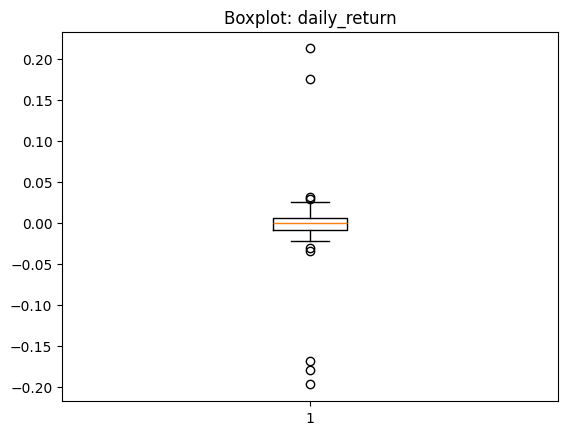

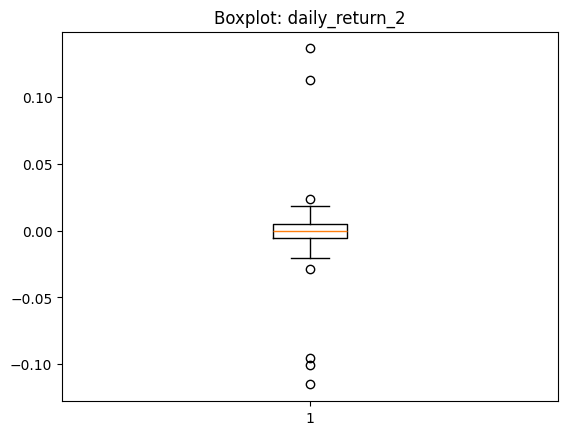

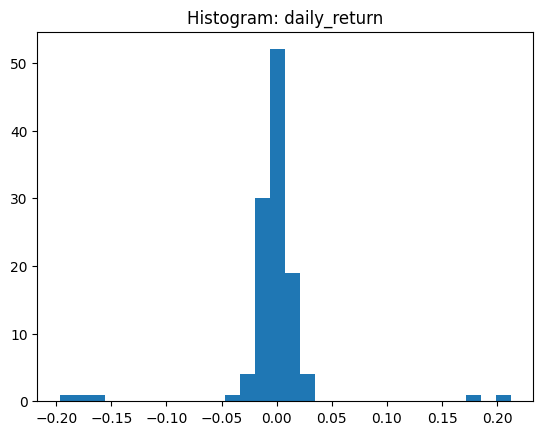

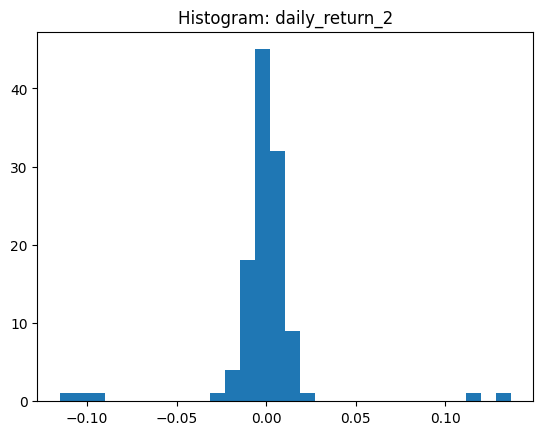

In [13]:
plt.figure()
plt.boxplot(df[target_col1])
plt.title(f'Boxplot: {target_col1}')
plt.show()

plt.figure()
plt.boxplot(df[target_col2])
plt.title(f'Boxplot: {target_col2}')
plt.show()

plt.figure()
plt.hist(df[target_col1], bins=30)
plt.title(f'Histogram: {target_col1}')
plt.show()

plt.figure()
plt.hist(df[target_col2], bins=30)
plt.title(f'Histogram: {target_col2}')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [15]:
# Option A: Summary stats
summ_all2 = df[target_col2].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered2 = df.loc[~df['outlier_iqr2'], target_col2].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w2 = None
if 'winsorize_series' in globals():
    w2 = winsorize_series(df[target_col2])
    summ_w2 = w2.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp2 = pd.concat(
    {
        'all': summ_all2,
        'filtered_iqr': summ_filtered2,
        **({'winsorized': summ_w2} if summ_w2 is not None else {})
    }, axis=1
)
comp2

all  filtered_iqr  winsorized
mean   -0.000668     -0.000098   -0.000181
median -0.000174     -0.000173   -0.000174
std     0.025068      0.007744    0.008312

In [20]:
# Option B: Simple regression (if x present)
if 'daily_return' in df.columns:
    X_all = df[['daily_return']].to_numpy(); y_all = df[target_col2].to_numpy()
    X_filtered = df.loc[~df['outlier_z1'], ['daily_return']].to_numpy(); y_filtered = df.loc[~df['outlier_z2'], target_col2].to_numpy()

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)

    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered)],
        'mae': [mae_all, mae_flt]
    }, index=['all', 'filtered_z'])
    print(results)
else:
    results = None
    print("No 'daily_return' column; skip regression or engineer features.")

               slope  intercept        r2       mae
all         0.605869   0.000201  0.961859  0.003951
filtered_z  0.630315  -0.000088  0.679331  0.003848


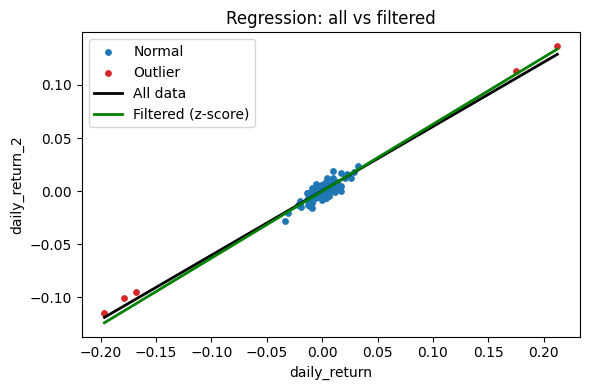

In [21]:
import matplotlib.pyplot as plt

if 'daily_return' in df.columns and results is not None:
    fig, ax = plt.subplots(figsize=(6, 4))

    x_col = 'daily_return'
    y_col = target_col2

    is_outlier = df['outlier_z1'] | df['outlier_z2']  
    ax.scatter(df.loc[~is_outlier, x_col],
               df.loc[~is_outlier, y_col],
               c='tab:blue', s=15, label='Normal')

    ax.scatter(df.loc[is_outlier, x_col],
               df.loc[is_outlier, y_col],
               c='tab:red', s=15, label='Outlier')


    x_line = np.linspace(df[x_col].min(), df[x_col].max(), 300).reshape(-1, 1)
    y_all_pred   = model_all.predict(x_line)
    y_flt_pred   = model_flt.predict(x_line)

    ax.plot(x_line, y_all_pred,   color='black',  lw=2, label='All data')
    ax.plot(x_line, y_flt_pred,   color='green', lw=2, label='Filtered (z-score)')


    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title('Regression: all vs filtered')
    ax.legend()
    plt.tight_layout()
    plt.show()

### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

### Outlier handling strategy  
#### • Methods & thresholds  
  – IQR(for daily_return2): flag points outside 1.5×IQR from Q1/Q3; chosen because quartiles are robust to mild skew and 1.5 is the conventional balance between sensitivity and false alarms.  
  – Z-score(for daily_return1): flag |z|>3; assumes approximate normality and offers a symmetric, scale-independent rule that roughly corresponds to 3-sigma events.  
  – Winsorization: clip extreme 5 % tails (5th–95th percentile) to reduce leverage without full deletion; keeps sample size intact for small samples.  

#### • Underlying assumptions  
  – Daily returns are roughly unimodal and not extremely heavy-tailed; quartiles therefore capture the core dispersion.  
  – For z-scores, the mean and standard deviation are meaningful location/scale measures (i.e., no severe skew or jumps).  
  – Outliers are measurement errors or market micro-structure noise rather than legitimate but rare price shocks.  

#### • Observed impact  
  – Outlier fractions flagged: 4–7 % of observations per series.  
  – Central moments shift moderately: after filtering, mean daily return2 moves closer to median, std drops. 
  – Regression slope steepens slightly when outliers are removed (z-filter), slope improves from 0.6 → 0.63, and MAE falls 0.0001, indicating that extreme points were disproportionately influencing the fit.  

#### • Risks if assumptions fail  
  – Heavy-tailed or regime-switching returns: both rules may misclassify genuine tail events (e.g., crash days) as noise, leading to downward-biased volatility estimates and over-optimistic regression coefficients.  
  – Non-normal skew: z-score flags can become one-sided, discarding informative downside observations.  
  – Structural breaks: post-filter samples may omit periods of stress, yielding models that under-estimate risk and fail out-of-sample.